In [1]:
import json
import pickle
import sys

from curl_cffi import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

sent: <object object at 0x116c1eaa0>


In [2]:
SYM = 'DIA'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_dow.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Generating derived columns...
(7043, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1998-01-20,43.827282,43.844660,43.045273,43.271186,43.827282,3.780256,1.012851,0.987709,0.990881
1998-01-21,43.288582,43.584008,42.975778,43.427606,43.288582,3.767889,0.996799,0.991569,0.991569
1998-01-22,42.923634,43.297260,42.784610,42.923634,42.923634,3.759423,1.000000,0.997571,1.004049
1998-01-23,42.819386,43.236457,42.437070,43.097433,42.819386,3.756991,0.993548,1.004058,1.004870
1998-01-26,42.993160,43.193007,42.784624,43.027916,42.993160,3.761041,0.999192,1.011722,0.997575
1998-01-27,43.497120,43.688278,42.862823,42.888890,43.497120,3.772695,1.014182,1.011586,1.001998
1998-01-28,44.001083,44.061906,43.497122,43.584011,44.001083,3.784214,1.009569,1.003554,0.999210
1998-01-29,44.157482,44.626688,43.870745,43.966324,44.157482,3.787762,1.004348,0.997835,1.006690
1998-01-30,44.061890,44.452894,43.914177,44.452894,44.061890,3.785595,0.991204,1.022480,1.017550


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
1998-01-20     43.844660
1998-01-21     43.584008
1998-01-22     43.297260
1998-01-23     43.236457
1998-01-26     43.193007
                 ...    
2026-01-12    496.339996
2026-01-13    495.959991
2026-01-14    491.940002
2026-01-15    495.829987
2026-01-16    496.000000
Name: high, Length: 7043, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2000-01-03', utc=True)  # first day of legit open/close values
SIM_START

Timestamp('2000-01-03 00:00:00+0000', tz='UTC')

In [7]:
len(df.index >= str(SIM_START.date()))

7043

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

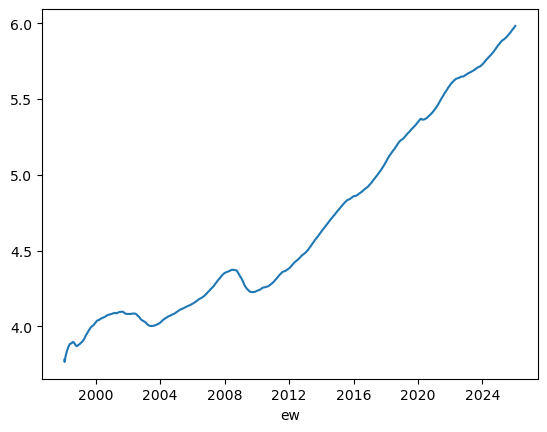

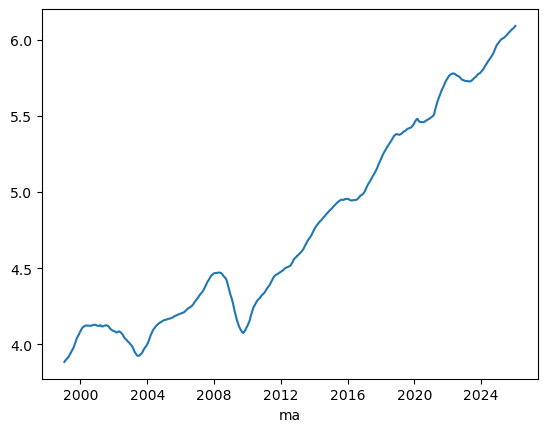

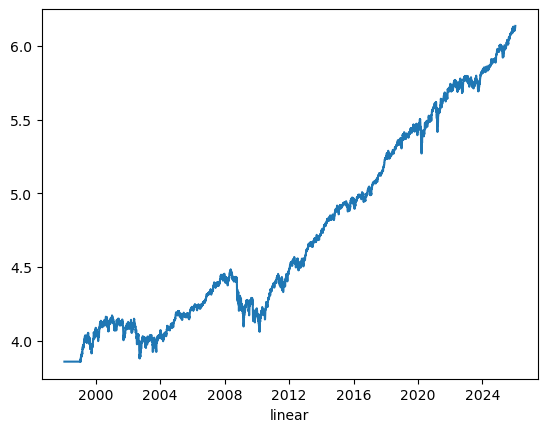

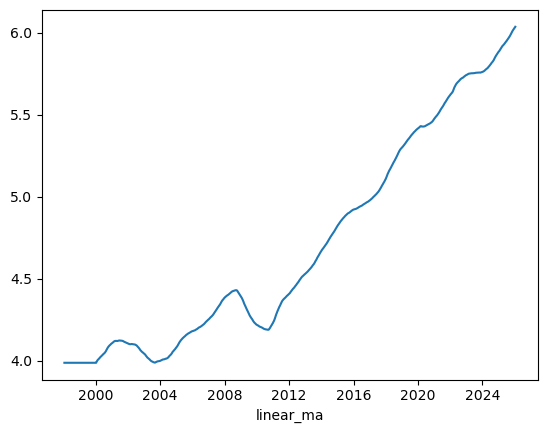

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= str(SIM_START.date()), :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[str(SIM_START.date()), 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params# = None, None

(55.741591518674824,
 {'time_param': 7,
  'method': 'ew',
  't': 0.9187322054617664,
  'k': 6.411118147381572,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 7.59694447381095
Round 1: 55.625137418425126
New best: 55.625137418425126
{'time_param': 7, 'method': 'ew', 't': 0.9187322054617664, 'k': 6.411118147381572, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


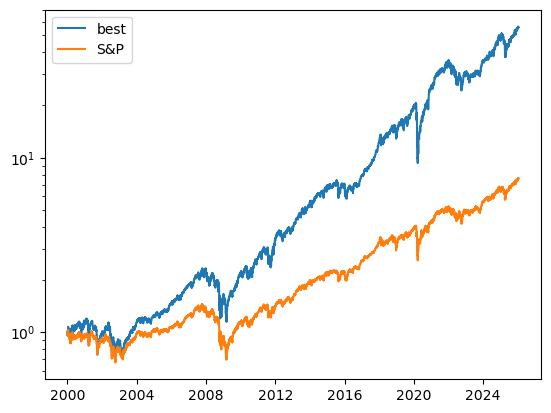

Round 2: 6.590919684341696
Round 3: 6.389314211989717
Round 4: 7.491630219326935
Round 5: 5.980073474361845
Round 6: 21.25225670507142
Round 7: 5.894814528861118
Round 8: 2.579412444223088
Round 9: 3.4945258457588793
Round 10: 26.923270511914613
Round 11: 2.8408321514914223
Round 12: 2.4660738045849087
Round 13: 1.4207018073504145
Round 14: 12.871515008133475
Round 15: 3.1456819901298765
Round 16: 4.82626398628731
Round 17: 14.628978191860611
Round 18: 13.953581180684505
Round 19: 2.052598596119127
Round 20: 23.815489566916344
Round 21: 30.676996607882668
Round 22: 4.5990257191184
Round 23: 20.899356683011952
Round 24: 1.1997318105304138
Round 25: 16.821467907396524
Round 26: 5.097323380161843
Round 27: 1.2912011660517773
Round 28: 30.515224304353957
Round 29: 1.5669890680776541
Round 30: 7.244810934679412
Round 31: 4.993781332208237
Round 32: 31.25352132881359
Round 33: 5.7363286352017155
Round 34: 5.8827036966694894
Round 35: 11.25582118006103
Round 36: 23.052572855939335
Round 37: 2

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 7.59694447381095
Round 1: 32.90864733369235
Round 2: 32.9043775872344
Round 3: 30.462021693239738
Round 4: 52.71737683862886
Round 5: 32.90966861513125
Round 6: 32.89758446115288
Round 7: 6.898749023465761
Round 8: 52.90540149721037
Round 9: 6.906543594270249
Round 10: 32.89940886982795

Factor: 1.03125
Do nothing res: 7.59694447381095
Round 1: 21.24886134677432
Round 2: 32.90595786479444
Round 3: 32.90076009101478
Round 4: 36.856284867281246
Round 5: 6.917068655451371
Round 6: 32.90349509346927
Round 7: 32.90544349417787
Round 8: 32.90484581250828
Round 9: 32.902872279665615
Round 10: 13.641077718027912

Factor: 1.015625
Do nothing res: 7.59694447381095
Round 1: 32.90497851314595
Round 2: 32.90506035539159
Round 3: 32.904318022189074
Round 4: 6.659010429942768
Round 5: 32.903832228605765
Round 6: 32.129855986580665
Round 7: 32.90568875875993
Round 8: 32.90406996277359
Round 9: 32.904699662188506
Round 10: 32.905001176442

Factor: 1.0078125
Do nothing res

In [20]:
# Force set:
#best_out = 33.55436395490332
#params_out = {'time_param': 153, 'method': 'ew', 't': 0.9977578507998721, 'k': 0.1502092583872895, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.999999999999998

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.5238568588469185

In [24]:
params_out

{'time_param': 7,
 'method': 'ew',
 't': 0.9187322054617664,
 'k': 6.411118147381572,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


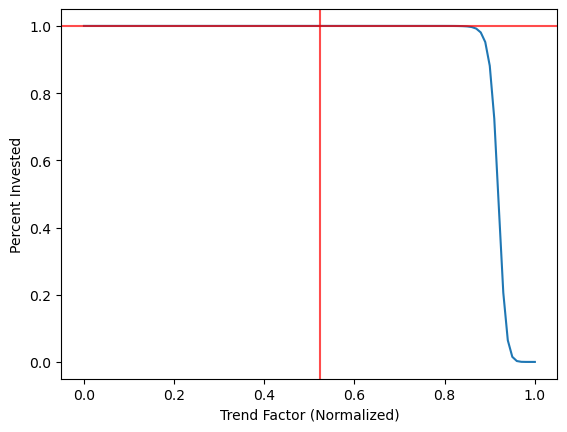

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

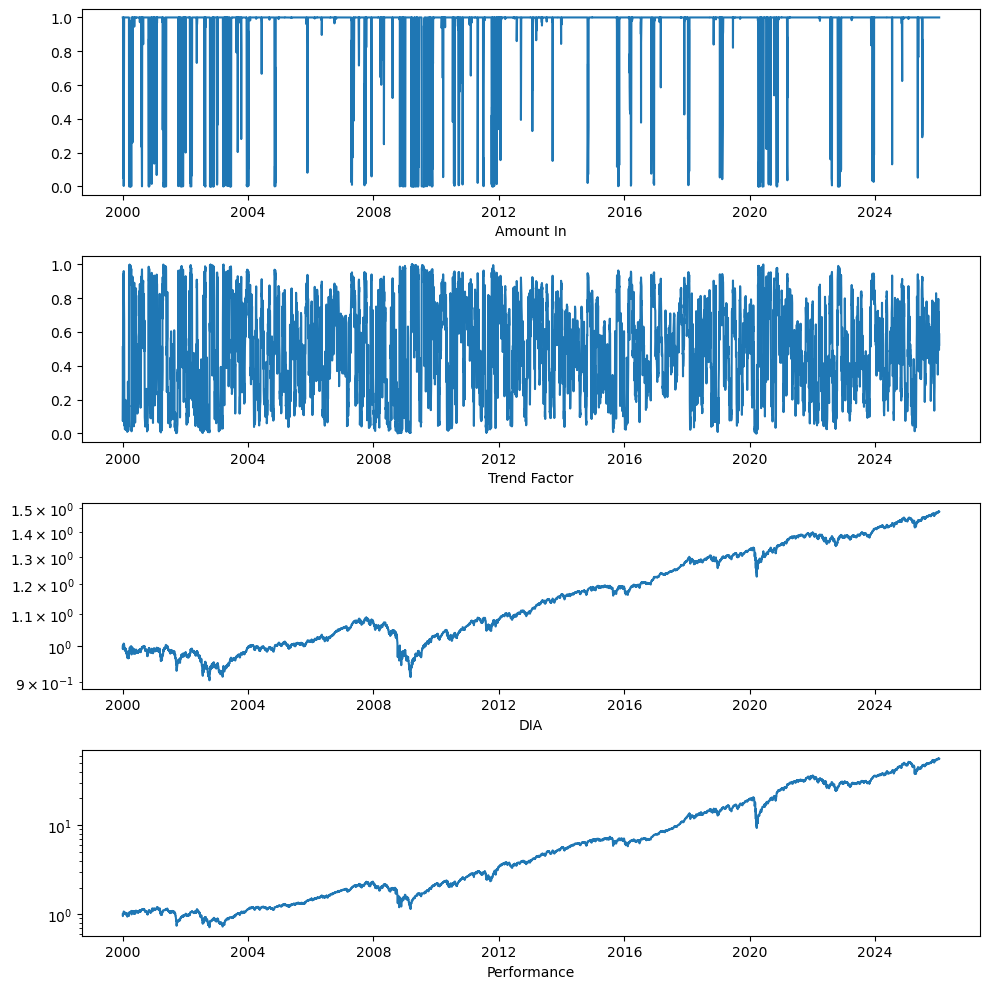

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('DIA')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

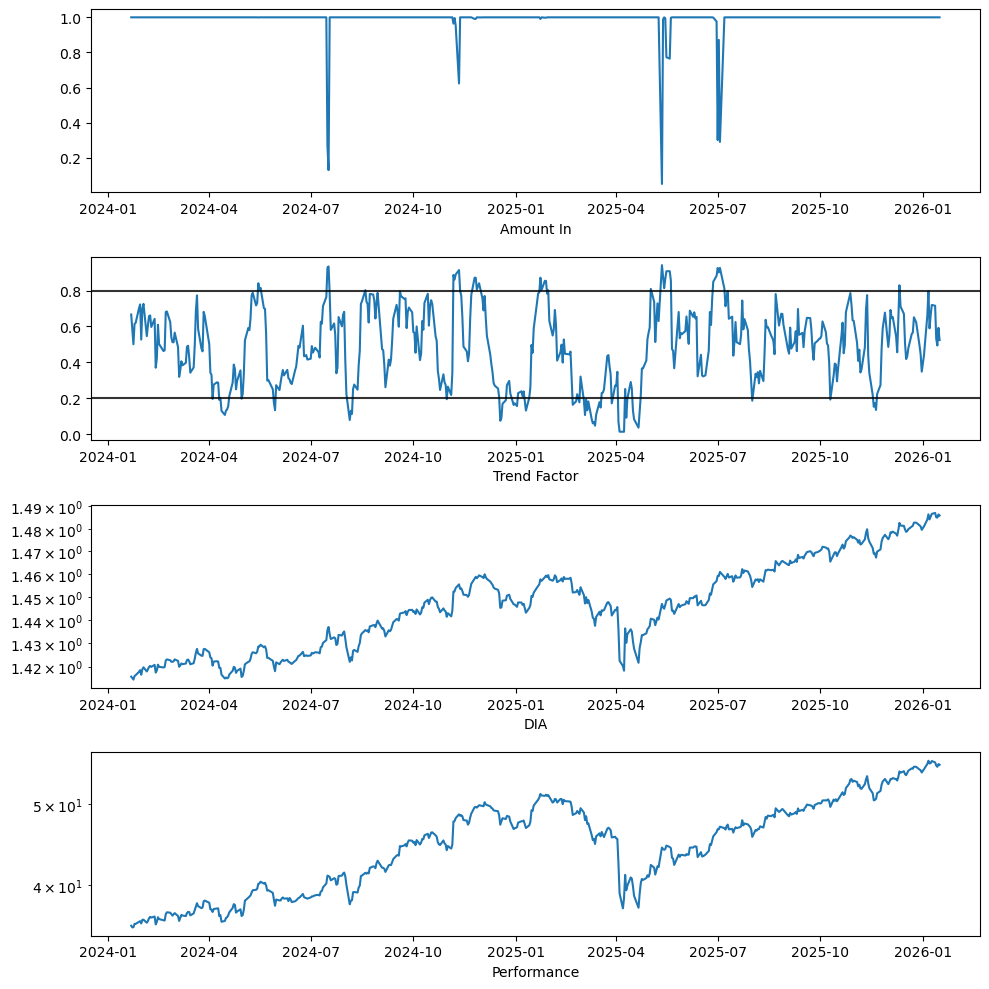

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')
plt.axhline(y=0.2, color='k', alpha=0.8)
plt.axhline(y=0.8, color='k', alpha=0.8)

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= str(SIM_START.date())).sum()
# n years
t = n / 250
# amt at start
p = df.loc[str(SIM_START.date()), 'value']
amt = df.iloc[-1].value
p, t, amt

(64.94979858398438, 26.2, 493.4200134277344)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.16577141107401427

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['dia'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.126046115645453, 1.0], 'dia': [1.1657714110740143, 1.0], 'nas': [1.245991026543851, 1.0], 'rus': [1.3131463662708152, 1.0], 'jpxn': [1.067609313829114, 1.0], 'ktec': [1.6317632641049638, 0.0], 'eem': [1.210138091847281, 1.0], 'nfty': [1.262556097182899, 1.0], 'gdx': [1.4205436128441207, 0.0]}


In [33]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(55.625137418425126,
 {'time_param': 7,
  'method': 'ew',
  't': 0.9187322054617664,
  'k': 6.411118147381572,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})